# Project n#2 : Insurance reviews

Annabel MERCERON - Romain GIRODET

DIA1 ESILV

The dataset contains information on reviews left by customers on an insurance product. Each row in the dataset includes a date, a note about the review, the author of the review, the text of the review, the insurer and the type of product.

Problematic : What is the reason when the rating is low ? This is probably THE most important question for insurers when
facing with all these reviews. 

Objectives :
- predict the ratings of the "test" dataset
- find the reasons why the ratings to some insurance companies are this low

NB: the code was very long to execute. We built the notebook so that the executions you will do are done on a small amount of data, and that each part is independent of each other (each part will look for the cleaned and vectorized datasets in the folder that we have provided to you).

--> this notebook is around 1min30 to execute

## Imports

### Libraries

In [2]:
import pandas as pd 
import string 
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import ast
import random

import nltk
from nltk import pos_tag, word_tokenize, TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

import gensim
from gensim.models import Word2Vec

from googletrans import Translator
translator = Translator()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error

### Fonction

In [3]:
def __encodeLatin_DecodeUTF8__(x):
    try:    
        return x.encode("latin1").decode("utf_8")
    except: 
        return None

def __clean_BREAKLINE__(x):
    return x.replace("\r","").replace("\n"," ").replace("_x000D_","").replace("\xa0en","")
    

def __strip_string__(x):
    return x.strip()

def __format_date_match__(x):
    token=x.split(" ")
    return ((token[1]==token[len(token)-2]) and (token[2]==token[len(token)-1]))

def __get_day_date__(x):
    return x.split(" ")[0]
def __get_day_month__(x):
    return x.split(" ")[1]
def __get_day_year__(x):
    return x.split(" ")[2]


def __remove_ponctuation__(x):
    for punctuation in string.punctuation:
        x=x.replace(punctuation,"")
    return x

def __lower__(x):
    return x.lower().strip()

def __from_french_to_english__(x):
    return translator.translate(x, dest='en').text

### Datasets

The dataset given to us contains reviews published by insurance customers. There are different columns :
- date: it contains the date of the publication of the review and the period of the review experience, and it has to be cleaned.
- note: it is the number of stars given by the customer (it should be predicted in the test dataset)
- auteur: the id of the customer
- avis: the review
- assureur: the name of the insurance
- produit: the type of insurance
Here is a first sight of what the dataset looks like :

In [4]:
#train_data=pd.read_csv("https://drive.google.com/uc?id=1r3ZwNtY1f7lWrYKgC-hk0GJCcoxSuTej",sep=";")
#test_data = pd.read_csv("https://drive.google.com/uc?id=1qsapCTYbmWFQdBWOCsXdwVlvU1-gOYHn", sep=";")

train_data = pd.read_excel("datasets/train.xlsx")
pd.set_option('mode.chained_assignment', None)
train_data

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, Ã©coute...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une rÃ©ponse trÃ¨s ra...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, trÃ¨s dÃ©Ã§u de ...",Matmut,auto
...,...,...,...,...,...,...
24100,22 mars 2...,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto
24101,06 dÃ©cem...,1,tzl-81680,MÃªme les demandes les plus simples n'aboutiss...,Allianz,habitation
24102,14 avril ...,1,jmr-72500-110395,"En dÃ©cembre 2019, j'ai souscrit Ã un contrat...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer Ã la gmf depuis plus de 15 an...,GMF,auto


## Cleaning

To prevent the execution from being too long, we suggest that you execute the following code with 1000 lines (the next part will fetch the complete cleaned dataset).

In [5]:
train_data=train_data[:500]
train_data

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, Ã©coute...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une rÃ©ponse trÃ¨s ra...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, trÃ¨s dÃ©Ã§u de ...",Matmut,auto
...,...,...,...,...,...,...
495,26 juille...,5,sylvie-m-124735,"Prix trÃ¨s attractif, rapiditÃ© de l'exÃ©cutio...",Direct Assurance,auto
496,13 octobr...,1,leila-115362,J ai eu un accident de la circulation j ai per...,Pacifica,auto
497,16 juille...,1,bobmorane-123574,"fuyez ce groupe, ils ne rÃ©pondent jamais aux ...",Ag2r La Mondiale,sante
498,28 juin 2...,3,benjamin-s-121433,Je suis satisfait des services simple et prati...,GMF,auto


### Suppression des données vides

In [6]:
# drop nan value
print(len(train_data))
train_data.dropna(inplace=True)
print(len(train_data))

train_data.head()

500
500


,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, Ã©coute...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une rÃ©ponse trÃ¨s ra...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, trÃ¨s dÃ©Ã§u de ...",Matmut,auto


### nettoyage colonne produit 

In [7]:
# Encodage et nettoyage des avis
train_data.produit=train_data.produit.apply(lambda x:__encodeLatin_DecodeUTF8__(x))
print(len(train_data))
train_data.dropna(subset=["produit"],inplace=True)
print(len(train_data))
train_data.produit=train_data.produit.apply(lambda x:__clean_BREAKLINE__(x))

#------------------------------------------
# remove ponctuacion 
train_data.produit=train_data.produit.apply(lambda x:__remove_ponctuation__(x))
# tout en minuscule
train_data.produit=train_data.produit.apply(lambda x:__lower__(x))

train_data.head(2)

500
500


,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, Ã©coute...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto


### nettoyage colonne assurance

In [8]:
train_data.assureur=train_data.assureur.apply(lambda x:__encodeLatin_DecodeUTF8__(x))
print(len(train_data))
train_data.dropna(subset=["assureur"],inplace=True)
print(len(train_data))
train_data.assureur=train_data.assureur.apply(lambda x:__clean_BREAKLINE__(x))


# remove ponctuacion 
train_data.assureur=train_data.assureur.apply(lambda x:__remove_ponctuation__(x))
# tout en minuscule
train_data.assureur=train_data.assureur.apply(lambda x:__lower__(x))

500
500


### nettoyage Colonne date 

In [9]:
# drop date wrong format
train_data.date=train_data.date.apply(lambda x:__strip_string__(x))

train_data["V"]=None
train_data["V"]=train_data.apply(lambda x :__format_date_match__(x.date),axis=1)
# df.groupby("V").count()
#143 False
#20 299 True

train_data=train_data[train_data.V==True]

In [10]:
# create 3 new column for date 

train_data["day_date"]=None
train_data["day_month"]=None
train_data["day_year"]=None


train_data["day_date"]=train_data.apply(lambda x:__get_day_date__(x.date),axis=1)
train_data["day_month"]=train_data.apply(lambda x:__get_day_month__(x.date),axis=1)
train_data["day_year"]=train_data.apply(lambda x:__get_day_year__(x.date),axis=1)

In [11]:
train_data.drop(labels=["date","V"],axis=1,inplace=True)
train_data.day_month=train_data.day_month.apply(lambda x:__encodeLatin_DecodeUTF8__(x))
train_data.head()

,note,auteur,avis,assureur,produit,day_date,day_month,day_year
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, Ã©coute...",direct assurance,auto,06,septembre,2021
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",direct assurance,auto,03,mai,2021
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,direct assurance,auto,21,mars,2021
3,4,boulain-f-116580,"je satisfait du service, une rÃ©ponse trÃ¨s ra...",lolivier assurance,auto,10,juin,2021
4,1,ouaille31-51798,"Client depuis plus de 25 ans, trÃ¨s dÃ©Ã§u de ...",matmut,auto,29,janvier,2017


### nettoyage colonne avis

In [12]:
# Encodage et nettoyage des avis
train_data.avis=train_data.avis.apply(lambda x:__encodeLatin_DecodeUTF8__(x))
print(len(train_data))
train_data.dropna(subset=["avis"],inplace=True)
print(len(train_data))
train_data.avis=train_data.avis.apply(lambda x:__clean_BREAKLINE__(x))


train_data.head()

496
419


,note,auteur,avis,assureur,produit,day_date,day_month,day_year
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",direct assurance,auto,06,septembre,2021
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",direct assurance,auto,03,mai,2021
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,direct assurance,auto,21,mars,2021
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",lolivier assurance,auto,10,juin,2021
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",matmut,auto,29,janvier,2017


In [13]:
#CLEAN avis

# remove ponctuacion 
train_data.avis=train_data.avis.apply(lambda x:__remove_ponctuation__(x))
# tout en minuscule
train_data.avis=train_data.avis.apply(lambda x:__lower__(x))

# train_data["avis_en"]=train_data.avis.apply(lambda x :__from_french_to_english__(x))
train_data.head()

,note,auteur,avis,assureur,produit,day_date,day_month,day_year
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,direct assurance,auto,06,septembre,2021
1,4,bernard-g-112497,je suis globalement satisfait sauf que vous a...,direct assurance,auto,03,mai,2021
2,5,virginie-t-107352,prix tres abordable plusieurs options soffrent...,direct assurance,auto,21,mars,2021
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,lolivier assurance,auto,10,juin,2021
4,1,ouaille31-51798,client depuis plus de 25 ans très déçu de cett...,matmut,auto,29,janvier,2017


Our clean dataset has been exported under the name "data_train_clean.csv" (or "test") and is used in the rest of the code

In [14]:
#train_data.to_csv("datasets/data_train_clean.csv",index=False)
#train_data

## Visualisation

For visualization, we have chosen several types of graphics:
- Number of insurers, number of insurance categories, number of ratings
- wordcloud to visualize the frequency of the terms used in reviews

In [15]:
train_clean=pd.read_csv("datasets/train_clean.csv")
train_clean.head()

,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...
1,4,bernard-g-112497,je suis globalement satisfait sauf que vous a...,Direct Assurance,auto,3,mai,2021,I am generally satisfied except that you have ...
2,5,virginie-t-107352,prix tres abordable plusieurs options soffrent...,Direct Assurance,auto,21,mars,2021,"very affordable price, several options are ava..."
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...
4,1,ouaille31-51798,client depuis plus de 25 ans très déçu de cett...,Matmut,auto,29,janvier,2017,customer for more than 25 years very disappoin...


The plotX function takes as input a dataframe df and a variable x (by default, "insurer"). It displays the number of reviews written according to the variable x.

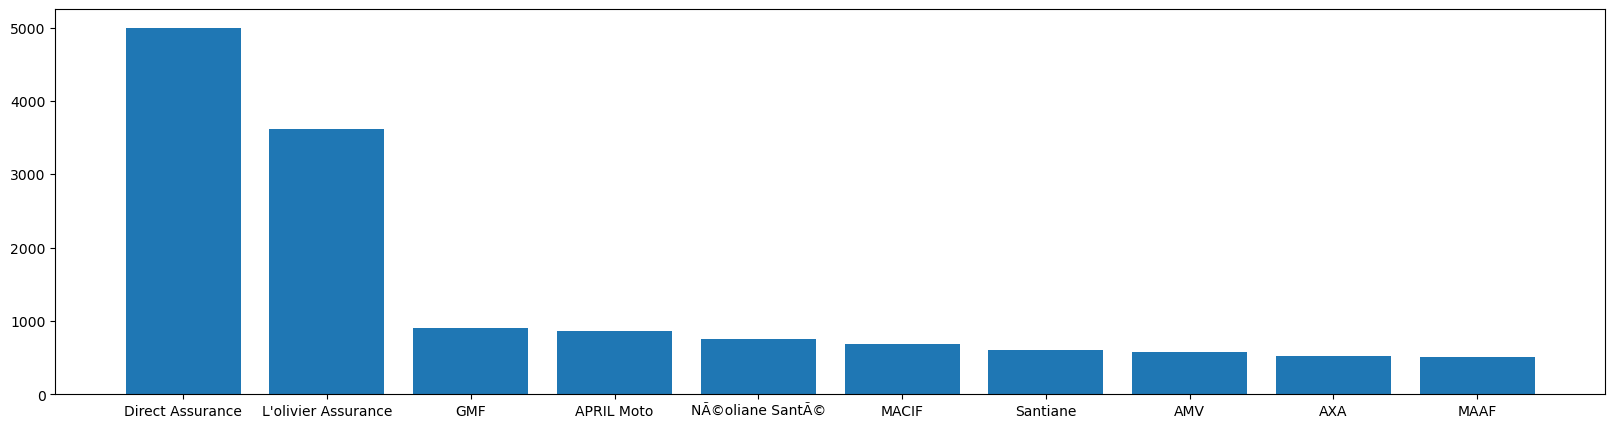

In [16]:
def plotX(df, x="assureur"):
    """affiche le nombre d'avis écrits en fonction de la variable x"""
    nbAvis = {}
    for i in range(len(df)):
        if df[x][i] in nbAvis:
            nbAvis[df[x][i]] += 1
        else:
            nbAvis[df[x][i]] = 1

    if x == "assureur":
        # Filtrer les assureurs ayant moins de 500 avis
        nbAvis = {k: v for k, v in nbAvis.items() if v >= 500}
        plt.figure(figsize=(20, 5))
    elif x == "produit":
        nbAvis = {k: v for k, v in nbAvis.items() if v >= 50}
        plt.figure(figsize=(15, 5))
    else :
        plt.figure(figsize=(10, 5))

    # Trier le dictionnaire par nombre d'avis décroissants
    nbAvis = dict(
        sorted(nbAvis.items(), key=lambda item: item[1], reverse=True))

    X = nbAvis.keys()
    Y = nbAvis.values()
    plt.bar(X, Y)

plotX(train_clean, x="assureur")

Thanks to the following graph, we realize that the vast majority of insurances present in the dataset are car insurances. It will not be surprising to find vocabulary specific to automobiles.

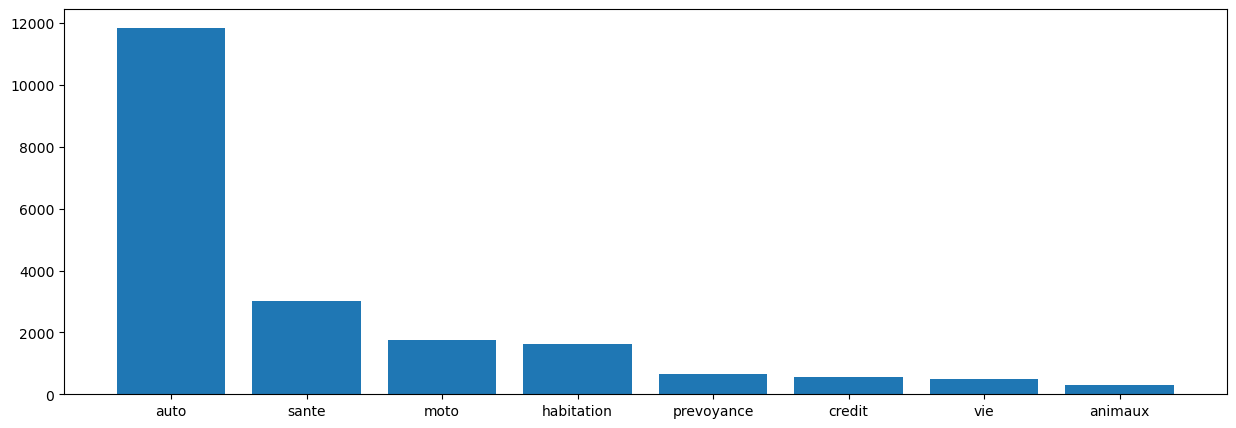

In [17]:
plotX(train_clean, x="produit")

The following function takes as input a dataframe containing the data to visualize and displays a word cloud displaying the most frequently used words in reviews.

It is important to note that to obtain meaningful and reliable results, it is necessary to properly clean and prepare the data before visualizing it. This can include steps like checking data quality and integrity, handling missing or outliers, and normalizing data.

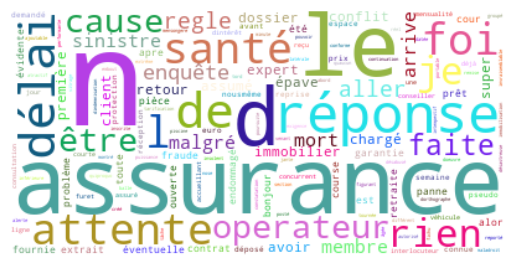

In [18]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
  # Générer une couleur aléatoire en RGB
  r = random.randint(0, 255)
  g = random.randint(0, 255)
  b = random.randint(0, 255)
  return f'rgb({r}, {g}, {b})'

def visualize_words(data):
  # Récupération des notes et des avis
  notes = data['note']
  avis = set()

  for i in data['avis']:
    mots = str(i).split(" ")
    # On ne prend que les mots de plus de 3 lettres
    mots = [mot for mot in mots if len(mot) > 3]
    avis.update(mots)

  avis = set(map(str, avis))

  # Création de la wordcloud avec un fond blanc et des couleurs plus diverses
  wordcloud = WordCloud(background_color='white', color_func=random_color_func).generate(' '.join(avis))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()



visualize_words(train_clean)

Thanks to the following graph, we see that the opinions mainly concern very negative opinions (1 out of 5), then very positive opinions (4 and 5/5). Few people put comments if their opinion is mixed.

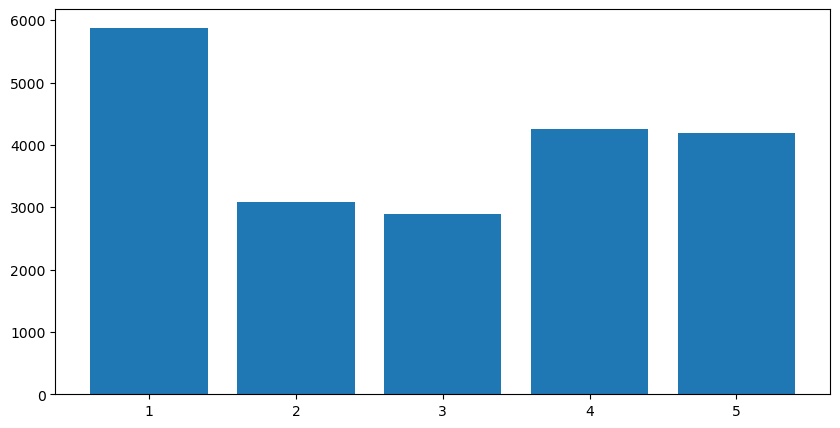

In [19]:
plotX(train_clean, x="note")

The following function takes as input a df dataframe containing your dataset data, and displays a heatmap that shows the number of ratings for each insurer and product combination.

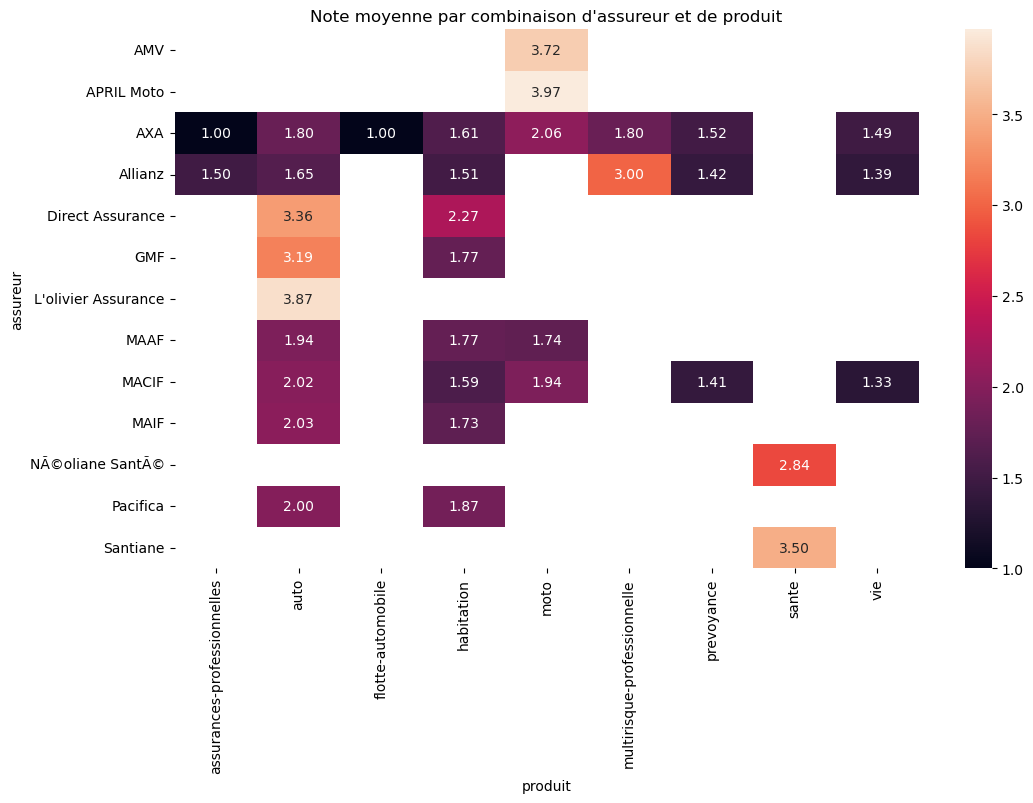

In [20]:
def visualize_assurers_and_products(df):
    # Calculer la note moyenne pour chaque combinaison d'assureur et de produit
    pivot_table = df.pivot_table(
        index='assureur', columns='produit', values='note', aggfunc='mean')

    # Compter le nombre de notes pour chaque assureur
    count_table = df.groupby('assureur')['note'].count()

    # Garder seulement les assureurs qui ont plus de 300 commentaires
    pivot_table = pivot_table[count_table > 400]

    # Retirer les colonnes qui n'ont aucune valeur
    pivot_table = pivot_table.dropna(axis=1, how='all')

    plt.figure(figsize=(12, 7))
    plt.title("Note moyenne par combinaison d'assureur et de produit")
    sns.heatmap(pivot_table, annot=True, fmt='.2f', mask=pivot_table.isnull())
    plt.show()



visualize_assurers_and_products(train_clean)


The following function takes as input a dataframe of data and displays a bar chart that shows the average rating for each insurer. If you want to view more detailed information, you can also use the groupby function to group the data by insurer and product, then use the pivot_table function to create a pivot table that displays the average ratings for each combination of insurer and product. product.

The following function takes as input a dataframe of data and displays a bar chart for each product, with the rating averages for each insurer.

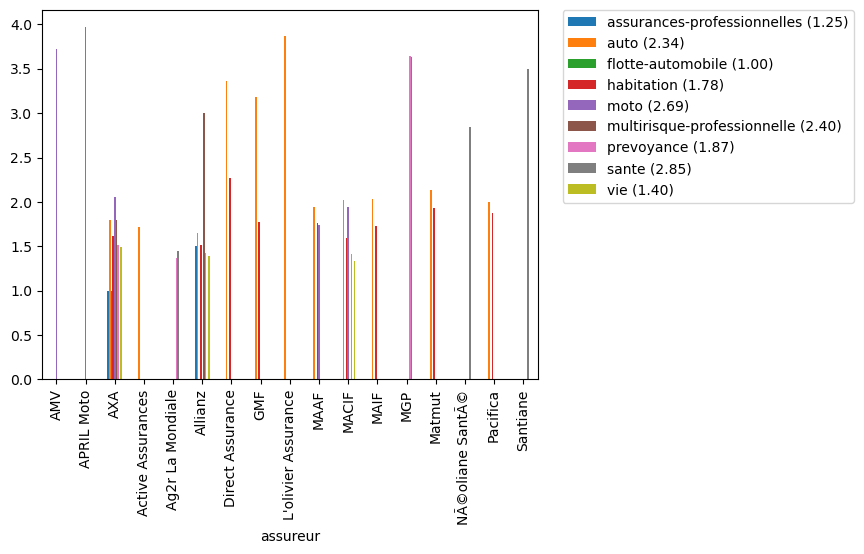

In [21]:
def visualize_assurer_product_ratings(data):
  ratings = data[['assureur', 'produit', 'note']].copy()

  # Compter le nombre de notes pour chaque assureur
  count_table = ratings.groupby('assureur')['note'].count()

  # Garder seulement les assureurs qui ont plus de 300 commentaires
  ratings = ratings[ratings['assureur'].isin(count_table[count_table > 300].index)]

  ratings = ratings.groupby(['assureur', 'produit']).mean()
  pivot_table = ratings.pivot_table(index='assureur', columns='produit', values='note')
  pivot_table.plot(kind='bar')

  # Récupérer les produits présents dans le diagramme
  products = pivot_table.columns[pivot_table.isnull().sum() < pivot_table.shape[0]]

  # Créer une liste de labels pour la légende en ne gardant que les produits présents dans le diagramme
  labels = [f"{product} ({pivot_table[product].mean():.2f})" for product in products]

  # afficher la légende à l'ext du graphe
  plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


visualize_assurer_product_ratings(train_clean)


## Word to vec

In [22]:
train_clean=pd.read_csv("datasets/train_clean.csv")
train_clean=train_clean[:15000]
train_clean

,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...
1,4,bernard-g-112497,je suis globalement satisfait sauf que vous a...,Direct Assurance,auto,3,mai,2021,I am generally satisfied except that you have ...
2,5,virginie-t-107352,prix tres abordable plusieurs options soffrent...,Direct Assurance,auto,21,mars,2021,"very affordable price, several options are ava..."
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...
4,1,ouaille31-51798,client depuis plus de 25 ans très déçu de cett...,Matmut,auto,29,janvier,2017,customer for more than 25 years very disappoin...
...,...,...,...,...,...,...,...,...,...
14995,2,alexfrz-59173,cela fait presque un an que je suis assuré pou...,APRIL Moto,moto,28,novembre,2017,it's been almost a year that I have been insur...
14996,2,barbaral-101040,jai été assurée pendant quelques années chez l...,L'olivier Assurance,auto,7,décembre,2020,I was insured for a few years with lolivier on...
14997,5,nicolas-a-115342,parfait pour mon utilisation tres limitée avec...,APRIL Moto,moto,30,mai,2021,perfect for my very limited use with minimum g...
14998,4,alexandra-99886,avis positif un bon contact jai eu des réponse...,GÃ©nÃ©ration,sante,9,novembre,2020,positive opinion a good contact I had answers ...


### Small functions

In [23]:
def __token__(x):
    return x.split(" ")


def __repartitionMots__(avis):
    """Fonction permettant de ne garder que les noms communs, adjectifs et verbes d'une liste de string en ANGLAIS"""
    #si prend en entrée une phrase :
    #avis=nltk.word_tokenize(avis)

    listTAG = nltk.pos_tag(avis)

    listRetour = []
    for i in range(len(listTAG)):
        if listTAG[i][1] == "RB" or listTAG[i][1] == "NN" or listTAG[i][1] == "VBD" or listTAG[i][1] == "JJ" or listTAG[i][1] == "VB":
            listRetour.append(listTAG[i][0])

    return listRetour


In [24]:
def __create_average_WordtoVec__(token): 

    try: 
        # token=x.split(" ")
        while '' in token: 
            token.remove('')

        return sum(model1.wv[token])/len(token)
    except:
        return None

In [25]:
def __get_vecteur_element__(x):
    return x[i]

### Tokenization of English reviews then vectorization

In [26]:
# get list all rating word
words=""
for a in train_clean.avis_en:   
    words=words+" "+"".join(a)

words=words.strip()

In [27]:
# tokenize list
tokenizer = TreebankWordTokenizer()
token_words=tokenizer.tokenize(words)

token_words=set(token_words)

token_words_reduce=__repartitionMots__(token_words)

In [28]:
train_clean["token_avis_en"] = train_clean.avis_en.apply(lambda x: __repartitionMots__(__token__(x)))
train_clean

,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en,token_avis_en
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...,"[insurance, speed, company, attractive, qualit..."
1,4,bernard-g-112497,je suis globalement satisfait sauf que vous a...,Direct Assurance,auto,3,mai,2021,I am generally satisfied except that you have ...,"[generally, satisfied, problem, website, impos..."
2,5,virginie-t-107352,prix tres abordable plusieurs options soffrent...,Direct Assurance,auto,21,mars,2021,"very affordable price, several options are ava...","[very, affordable, price,, several, available,..."
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...,"[satisfied, service, very, quick, response, se..."
4,1,ouaille31-51798,client depuis plus de 25 ans très déçu de cett...,Matmut,auto,29,janvier,2017,customer for more than 25 years very disappoin...,"[customer, very, disappointed, mutual, no, mut..."
...,...,...,...,...,...,...,...,...,...,...
14995,2,alexfrz-59173,cela fait presque un an que je suis assuré pou...,APRIL Moto,moto,28,novembre,2017,it's been almost a year that I have been insur...,"[it's, almost, year, satelis, scooter, unfortu..."
14996,2,barbaral-101040,jai été assurée pendant quelques années chez l...,L'olivier Assurance,auto,7,décembre,2020,I was insured for a few years with lolivier on...,"[was, few, several, was, last, contract, telep..."
14997,5,nicolas-a-115342,parfait pour mon utilisation tres limitée avec...,APRIL Moto,moto,30,mai,2021,perfect for my very limited use with minimum g...,"[perfect, very, limited, use, minimum, not, ha..."
14998,4,alexandra-99886,avis positif un bon contact jai eu des réponse...,GÃ©nÃ©ration,sante,9,novembre,2020,positive opinion a good contact I had answers ...,"[positive, opinion, good, contact, had, nothin..."


We select only the words present once:

In [29]:
def supprDoublons(liste):
    newList=[]
    for i in liste:
        if i not in newList:
            newList.append(i)
    return newList

train_clean["token_avis_en"] = train_clean["token_avis_en"].apply(lambda x: supprDoublons(x))
train_clean

,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en,token_avis_en
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...,"[insurance, speed, company, attractive, qualit..."
1,4,bernard-g-112497,je suis globalement satisfait sauf que vous a...,Direct Assurance,auto,3,mai,2021,I am generally satisfied except that you have ...,"[generally, satisfied, problem, website, impos..."
2,5,virginie-t-107352,prix tres abordable plusieurs options soffrent...,Direct Assurance,auto,21,mars,2021,"very affordable price, several options are ava...","[very, affordable, price,, several, available,..."
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...,"[satisfied, service, very, quick, response, th..."
4,1,ouaille31-51798,client depuis plus de 25 ans très déçu de cett...,Matmut,auto,29,janvier,2017,customer for more than 25 years very disappoin...,"[customer, very, disappointed, mutual, no, sea..."
...,...,...,...,...,...,...,...,...,...,...
14995,2,alexfrz-59173,cela fait presque un an que je suis assuré pou...,APRIL Moto,moto,28,novembre,2017,it's been almost a year that I have been insur...,"[it's, almost, year, satelis, scooter, unfortu..."
14996,2,barbaral-101040,jai été assurée pendant quelques années chez l...,L'olivier Assurance,auto,7,décembre,2020,I was insured for a few years with lolivier on...,"[was, few, several, last, contract, telephone,..."
14997,5,nicolas-a-115342,parfait pour mon utilisation tres limitée avec...,APRIL Moto,moto,30,mai,2021,perfect for my very limited use with minimum g...,"[perfect, very, limited, use, minimum, not, ha..."
14998,4,alexandra-99886,avis positif un bon contact jai eu des réponse...,GÃ©nÃ©ration,sante,9,novembre,2020,positive opinion a good contact I had answers ...,"[positive, opinion, good, contact, had, nothin..."


### Vectorization

In [30]:
# vectorise list
model1 = gensim.models.Word2Vec([token_words_reduce], min_count = 1, vector_size = 10, window = 5)
# model1.wv['motorcycle', 'insurance']
model1.wv['insurance']

array([ 0.07502165, -0.04418221, -0.07263685, -0.03932969, -0.09987155,
       -0.04933677,  0.08097836, -0.08331706, -0.08478477, -0.05623868],
      dtype=float32)

In [31]:
# créer colonne vecteur_moyenne
train_clean["vecteur_moyen"] = train_clean.apply(lambda x: __create_average_WordtoVec__(x.token_avis_en), axis=1)

print(len(train_clean))
train_clean.dropna(inplace=True)
print(len(train_clean))


15000
4147


In [32]:
# créer colonne elements du vecteur 

for i in range(len(train_clean.vecteur_moyen.iloc[0])):
    col_name="vecteur_"+str(i)

    train_clean[col_name]=None
    train_clean[col_name]=train_clean.vecteur_moyen.apply(lambda x: __get_vecteur_element__(x) )

train_clean.head()


,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en,token_avis_en,...,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,vecteur_8,vecteur_9
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...,"[insurance, speed, company, attractive, qualit...",...,0.046828,-0.067621,-0.014547,-0.004661,-0.020108,-0.011890,-0.028811,-0.041807,-0.024231,-0.002463
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...,"[satisfied, service, very, quick, response, th...",...,-0.003421,0.020296,0.015132,-0.018820,0.024904,-0.027872,0.004118,-0.034321,0.012173,0.003160
9,1,rezo31-62544,generali assurances vie patrimoine très mauvai...,Generali,vie,21,mars,2018,generali life insurance patrimony very bad cus...,"[generali, life, insurance, patrimony, very, b...",...,-0.040419,-0.001535,0.016901,-0.002098,-0.002457,-0.003985,-0.006792,-0.015829,0.019155,-0.013432
11,5,re-v-109323,totalement satisfaite de la qualité des prises...,L'olivier Assurance,auto,6,avril,2021,totally satisfied with the quality of the tele...,"[totally, satisfied, quality, telephone, suppo...",...,-0.007345,-0.005304,-0.003778,-0.003248,0.005517,-0.028660,-0.001225,0.008690,0.022014,0.000577
13,4,vas-m-117400,je suis très satisfait du service des conseils...,L'olivier Assurance,auto,17,juin,2021,I am very satisfied with the service of the ad...,"[very, satisfied, service, advice, adviser, ha...",...,-0.000460,-0.021991,0.006522,-0.013871,0.028252,0.013941,0.000064,-0.028011,0.012140,-0.002352


In [33]:
train_clean.drop(['auteur', 'avis', 'assureur', 'produit', 'day_date','day_month', 'day_year', 'avis_en'],axis=1)
train_clean.head(2)


,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en,token_avis_en,...,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,vecteur_8,vecteur_9
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...,"[insurance, speed, company, attractive, qualit...",...,0.046828,-0.067621,-0.014547,-0.004661,-0.020108,-0.011890,-0.028811,-0.041807,-0.024231,-0.002463
3,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...,"[satisfied, service, very, quick, response, th...",...,-0.003421,0.020296,0.015132,-0.018820,0.024904,-0.027872,0.004118,-0.034321,0.012173,0.003160


In [34]:
train_clean.to_csv("datasets/train_vect.csv",index=False)


## Supervised Learning

Below, we directly import the models that we built during the realization of the project. To see how we built these models, see the "Supervised Leaning" notebook in the "models" folder. There you will find our code as well as all the models we have built and stored.

In [35]:
test=pd.read_csv("datasets/test_enc.csv")
X_test=test[test.columns[test.columns!="note"]]
y_test=test[test.columns[test.columns=="note"]]
test.head(2)

,note,day_date,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,...,assureur_malakoff_humanis,assureur_metlife,assureur_mma,assureur_néoliane_santé,assureur_santévet,assureur_sma,assureur_sogecap,assureur_suravenir,produit_garantiedecennale,produit_responsabilitecivileprofessionnelle
0,5.0,7,-0.002979,0.025995,-0.010212,0.012139,0.010351,-0.015461,-0.010013,-0.006830,...,0,0,0,0,0,0,0,0,0,0
1,3.0,30,-0.008020,0.020905,0.027659,-0.000744,0.027265,-0.012828,0.004051,-0.005684,...,0,0,0,0,0,0,0,0,0,0


In [36]:
train=pd.read_csv("datasets/train_enc.csv")
X_train=train[train.columns[train.columns!="note"]]
y_train=train[train.columns[train.columns=="note"]]
train.head(2)

,note,day_date,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,...,day_mounth_mars,day_mounth_novembre,day_mounth_octobre,day_mounth_septembre,day_year_2016,day_year_2017,day_year_2018,day_year_2019,day_year_2020,day_year_2021
0,1,21,0.002848,0.034176,0.018522,-0.016716,0.018529,-0.003764,0.030136,0.004864,...,1,0,0,0,0,0,1,0,0,0
1,5,6,0.003707,-0.007725,-0.014924,-0.007306,0.013408,-0.001732,0.021056,-0.004091,...,0,0,0,0,0,0,0,0,0,1


In [37]:
test = test[train.columns]
train = train[train.columns]

In [38]:
from  sklearn.ensemble import GradientBoostingRegressor
from  sklearn.linear_model import LinearRegression
from  sklearn.linear_model import Ridge
from  sklearn.linear_model import BayesianRidge
from  sklearn.ensemble import RandomForestRegressor

In [39]:
model_0=GradientBoostingRegressor(random_state=3265)
model_1=LinearRegression(n_jobs=-1)
model_2=Ridge(random_state=3265)
model_3=BayesianRidge()
model_4=RandomForestRegressor(n_jobs=-1, random_state=3265)

In [40]:
model_0.fit(X_train,y_train.values.ravel())
model_1.fit(X_train,y_train.values.ravel())
model_2.fit(X_train,y_train.values.ravel())
model_3.fit(X_train,y_train.values.ravel())
model_4.fit(X_train,y_train.values.ravel())

RandomForestRegressor(n_jobs=-1, random_state=3265)

In [41]:
dico_rmse={"GradientBoostingRegressor":0,
"LinearRegression":0,
"Ridge":0,
"BayesianRidge":0,
"RandomForestRegressor":0,
}

dico_rmse["GradientBoostingRegressor"]=mean_squared_error(y_test, model_0.predict(X_test), squared=False)
dico_rmse["LinearRegression"]=mean_squared_error(y_test, model_1.predict(X_test), squared=False)
dico_rmse["Ridge"]=mean_squared_error(y_test, model_2.predict(X_test), squared=False)
dico_rmse["BayesianRidge"]=mean_squared_error(y_test, model_3.predict(X_test), squared=False)
dico_rmse["RandomForestRegressor"]=mean_squared_error(y_test, model_4.predict(X_test), squared=False)

dico_rmse

c:\Users\julia\anaconda3\envs\NLP_Ingredient\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\julia\anaconda3\envs\NLP_Ingredient\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\julia\anaconda3\envs\NLP_Ingredient\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\julia\anaconda3\envs\NLP_Ingredient\lib\site-pack

{'GradientBoostingRegressor': 1.9946132181730996,
 'LinearRegression': 1.9301618188466707,
 'Ridge': 1.7480235909556432,
 'BayesianRidge': 1.7479724342316223,
 'RandomForestRegressor': 1.5368648496237738}

## Unsupervised learning

We created an unsupervised model to better understand the reviews, and created segmentations that we could interpret. 
Indeed, we could explain what topics are present in the dataset and train a word embedding model and analyze similar words and word analogies.

### Creation of a One_Hot dataset

To prevent the execution from being too long, we suggest that you execute the following code with 100 lines just to have an overview of what our code does (the next part will fetch the complete OneHot dataset).

In [42]:
train_OneHot = pd.read_csv("datasets/train_vect.csv")
train_OneHot

,note,auteur,avis,assureur,produit,day_date,day_month,day_year,avis_en,token_avis_en,...,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,vecteur_8,vecteur_9
0,5,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,6,septembre,2021,best insurance prices solutions listening spee...,"['insurance', 'speed', 'company', 'attractive'...",...,0.046828,-0.067621,-0.014547,-0.004661,-0.020108,-0.011890,-0.028811,-0.041807,-0.024231,-0.002463
1,4,boulain-f-116580,je satisfait du service une réponse très rapid...,L'olivier Assurance,auto,10,juin,2021,I am satisfied with the service a very quick r...,"['satisfied', 'service', 'very', 'quick', 'res...",...,-0.003421,0.020296,0.015132,-0.018820,0.024904,-0.027872,0.004118,-0.034321,0.012173,0.003160
2,1,rezo31-62544,generali assurances vie patrimoine très mauvai...,Generali,vie,21,mars,2018,generali life insurance patrimony very bad cus...,"['generali', 'life', 'insurance', 'patrimony',...",...,-0.040419,-0.001535,0.016901,-0.002098,-0.002457,-0.003985,-0.006792,-0.015829,0.019155,-0.013432
3,5,re-v-109323,totalement satisfaite de la qualité des prises...,L'olivier Assurance,auto,6,avril,2021,totally satisfied with the quality of the tele...,"['totally', 'satisfied', 'quality', 'telephone...",...,-0.007345,-0.005304,-0.003778,-0.003248,0.005517,-0.028660,-0.001225,0.008690,0.022014,0.000577
4,4,vas-m-117400,je suis très satisfait du service des conseils...,L'olivier Assurance,auto,17,juin,2021,I am very satisfied with the service of the ad...,"['very', 'satisfied', 'service', 'advice', 'ad...",...,-0.000460,-0.021991,0.006522,-0.013871,0.028252,0.013941,0.000064,-0.028011,0.012140,-0.002352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,1,arthus-71812,metlive refuse de me rembourser les sommes de ...,MetLife,credit,2,mars,2019,metlive refuses to reimburse me the sums of 18...,"['metlive', 'reimburse', '1-year', 'advance', ...",...,0.030935,-0.000864,-0.001211,0.002954,0.009559,-0.005983,0.013711,-0.001708,-0.011047,-0.016271
4143,1,daga-50131,aucun service obtenir une réponse quand on es...,MAAF,habitation,10,décembre,2016,no service getting an answer when you are a cu...,"['service', 'answer', 'customer', 'constant', ...",...,-0.044145,0.021699,-0.018534,0.011641,0.005006,-0.015054,-0.012787,-0.021957,0.038689,-0.014257
4144,5,lionel-g-124020,excellent service et accueil les conseillers s...,GMF,auto,21,juillet,2021,excellent service and welcome the advisers are...,"['excellent', 'service', 'welcome', 'top', 've...",...,-0.020091,0.010614,0.007641,0.003109,0.032802,-0.014589,-0.000866,-0.026691,-0.004740,0.027216
4145,5,jean-claude-m-128201,prix compétitifs informations simples et site ...,Direct Assurance,auto,16,août,2021,competitive prices simple information and user...,"['competitive', 'simple', 'information', 'user...",...,-0.011409,-0.025019,-0.020019,-0.019072,-0.027619,0.005717,0.016647,-0.005915,0.007727,0.015159


In [43]:
train_OneHot = pd.read_csv("datasets/train_vect.csv")
train_OneHot=train_OneHot[:100]
train_OneHot.drop(["vecteur_moyen", "token_avis_en", "assureur", "produit", "day_date", "day_month", "day_year", "auteur", "avis", "vecteur_0",
        "vecteur_1", "vecteur_2", "vecteur_3", "vecteur_4", "vecteur_5", "vecteur_6", "vecteur_7", "vecteur_8", "vecteur_9"], axis=1, inplace=True)



In [44]:
print(train_OneHot.shape)
train_OneHot.dropna(subset=["avis_en"],inplace=True)
print(train_OneHot.shape)

(100, 2)
(100, 2)


In [45]:
train_OneHot.shape
train

,note,day_date,vecteur_0,vecteur_1,vecteur_2,vecteur_3,vecteur_4,vecteur_5,vecteur_6,vecteur_7,...,day_mounth_mars,day_mounth_novembre,day_mounth_octobre,day_mounth_septembre,day_year_2016,day_year_2017,day_year_2018,day_year_2019,day_year_2020,day_year_2021
0,1,21,0.002848,0.034176,0.018522,-0.016716,0.018529,-0.003764,0.030136,0.004864,...,1,0,0,0,0,0,1,0,0,0
1,5,6,0.003707,-0.007725,-0.014924,-0.007306,0.013408,-0.001732,0.021056,-0.004091,...,0,0,0,0,0,0,0,0,0,1
2,4,17,-0.002344,0.016518,0.008020,0.013505,-0.018214,-0.005674,-0.005325,-0.000942,...,0,0,0,0,0,0,0,0,0,1
3,3,23,0.017444,-0.008166,0.007015,0.003375,0.000520,-0.022202,-0.022418,0.006394,...,0,0,0,0,0,0,0,0,0,1
4,1,16,-0.006769,0.004720,0.013905,-0.002587,-0.002178,0.007890,0.021253,0.000877,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5411,5,24,0.000610,0.011581,0.019823,0.023925,-0.007281,-0.014311,-0.066189,0.001634,...,0,0,0,0,0,0,0,0,0,1
5412,3,5,0.014101,0.003323,-0.018424,-0.035115,-0.025072,-0.019209,0.030329,-0.028393,...,0,0,0,0,0,0,0,0,0,1
5413,4,25,-0.009040,0.003282,0.030999,0.003286,0.006155,0.001239,-0.030859,0.000405,...,1,0,0,0,0,0,0,0,0,1
5414,4,19,0.006327,0.015640,0.009176,-0.010026,0.006154,-0.001028,0.003560,-0.029275,...,1,0,0,0,0,0,0,0,0,1


In [46]:
train_OneHot["avis_en"] = train_OneHot.avis_en.apply(lambda x: __repartitionMots__(__token__(x)))
train_OneHot.head()

,note,avis_en
0,5,"[insurance, speed, company, attractive, qualit..."
1,4,"[satisfied, service, very, quick, response, se..."
2,1,"[generali, life, insurance, patrimony, very, b..."
3,5,"[totally, satisfied, quality, telephone, suppo..."
4,4,"[very, satisfied, service, advice, adviser, ha..."


In [47]:
def remove_mot_inf_3(liste_avis):
    liste = []
    for i in liste_avis:
        if len(i)>3:
            liste.append(i)
    return liste


def remove_punctuation(liste_avis):
    for x in liste_avis:
        for punctuation in string.punctuation:
            x=x.replace(punctuation,"")
    return liste_avis

def remove_digit(liste_avis):
    liste=[]
    for i in liste_avis:
        if not any(chr.isdigit() for chr in i):
            liste.append(i)
    return liste

def __Create_OneHot_Colonnes__(x, name):
    if name in x["avis_en"]:
        return 1
    else:
        return 0


In [48]:
def __Create_dfOneHot__(df):
    df_OneHot=df.copy()
    liste_avis=[]

    #collecte de tous les avis dans une list : liste_avis
    for i in range(len(df)):
        for mot in df_OneHot["avis_en"][i]:
            liste_avis.append(mot)

    #suppression des avis doublons et nettoyage
    liste_avis = remove_punctuation(liste_avis)
    liste_avis = remove_mot_inf_3(liste_avis)
    liste_avis = remove_digit(liste_avis)
    liste_avis = [PorterStemmer().stem(x) for x in liste_avis]
    liste_avis_uniques = np.unique(liste_avis).tolist()
    if "note" in liste_avis_uniques:
        liste_avis_uniques.remove("note")
    
    #One Hot Encoding  
    for name in liste_avis_uniques:
        df_OneHot[name] = df_OneHot.apply(lambda x: __Create_OneHot_Colonnes__(x, name), axis=1)

    return (df_OneHot,liste_avis_uniques)

In [49]:
(train_OneHot,liste_avis_uniques)=__Create_dfOneHot__(train_OneHot)
train_OneHot.head()

,note,avis_en,abl,absolut,accept,access,accid,action,addit,advanc,...,went,were,wish,work,world,worri,worry-fre,year,young,zenup
0,5,"[insurance, speed, company, attractive, qualit...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,"[satisfied, service, very, quick, response, se...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"[generali, life, insurance, patrimony, very, b...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,"[totally, satisfied, quality, telephone, suppo...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,"[very, satisfied, service, advice, adviser, ha...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# train_OneHot.to_csv("datasets/train_OneHot.csv",index=False)

### All notes

First, we would like to locate the topics in the notes. We start with all the notes, good or bad.

In [51]:
train_OneHot = pd.read_csv("datasets/train_OneHot.csv", dtype={"avis_en": str})
train_OneHot["avis_en"] = train_OneHot["avis_en"].apply(lambda x : ast.literal_eval(x))

train_OneHot.head(2)

,note,avis_en,abandon,abber,aberr,abil,abl,abnorm,abomin,abreast,...,wrote,yamaha,yassin,year,yearsi,yearspo,yesterday,youdriv,youness,young
0,5,"[insurance, speed, company, attractive, qualit...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,"[satisfied, service, very, quick, response, se...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
def formatAvisEn(ligne):
    retour=""
    for i in ligne:
        retour+=str(i)+" "
    return retour

train_OneHot["avis_en"]=train_OneHot["avis_en"].apply(lambda x: str(formatAvisEn(x)))
train_OneHot.head()

,note,avis_en,abandon,abber,aberr,abil,abl,abnorm,abomin,abreast,...,wrote,yamaha,yassin,year,yearsi,yearspo,yesterday,youdriv,youness,young
0,5,insurance speed company attractive quality spe...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,satisfied service very quick response service ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,generali life insurance patrimony very bad cus...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,totally satisfied quality telephone support al...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,very satisfied service advice adviser had tele...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We want to do a PCA to all the vectors, so we can create visual clusters on a 2D map.

In [53]:
def Visualisation_2D_Dataframe_K_Cluster (df, nb_cluster, color):
    """visualisation des différents clusters des avis mis par des usagers à propos des assureurs"""
    df_OneHot=df.copy()
    X = df_OneHot[df_OneHot.columns[~df_OneHot.columns.isin(["avis_en", "note"])]]
    Y = df_OneHot["avis_en"]

    # PCA 2 dimension 
    pca = PCA(n_components=2)
    components=pca.fit_transform(X)
    # Create 3 col dataframe : produits | component 0 | component 1
    df_2dim=pd.DataFrame(components,columns=["component_0","component_1"])

    #clustering =DBSCAN(eps=0.01).fit(X)
    clustering =KMeans(n_clusters=nb_cluster).fit(X)
    df_2dim["label"]=clustering.labels_
    df_2dim["label"]=df_2dim["label"].apply(lambda x: str(x))
    df_2dim["avis_en"]=Y

    # Get the 10 most common words in each cluster
    common_words = []
    if color=="note" :
        fig = px.scatter(df_2dim, x=df_2dim["component_0"], y=df_2dim["component_1"], color=df_OneHot["note"], hover_name=df["avis_en"])
    elif color=="kmean" :
        fig = px.scatter(df_2dim, x=df_2dim["component_0"], y=df_2dim["component_1"], color=df_2dim["label"], hover_name=df["avis_en"])
        for cluster in range(nb_cluster):
            cluster_words = " ".join([str(x) for x in df_2dim[df_2dim["label"]== str(cluster)]["avis_en"]])
            cluster_counter = Counter(cluster_words.split())
            common_words.append(cluster_counter.most_common(10))
    else :        
        fig = px.scatter(df_2dim, x=df_2dim["component_0"], y=df_2dim["component_1"], color=df_2dim["label"], hover_name=df["avis_en"])

        
    fig.show()

    return common_words


On this first map, we see the clusters made using the Kmeans function. We can clearly see here the different clusters that stand out from each other. We also notice that each cluster has words that come up more frequently, such as the word "satisfied" for one cluster, or "long" and "today" for another.

In [54]:
common_words = Visualisation_2D_Dataframe_K_Cluster(train_OneHot, 5, "kmean")
for cluster, words in enumerate(common_words):
    print(f"Cluster {cluster}: {words}")

Cluster 0: [('very', 1602), ('insurance', 1169), ('not', 1050), ('service', 982), ('satisfied', 932), ('was', 499), ('customer', 471), ('contract', 400), ('be', 398), ('thank', 315)]
Cluster 1: [('insurance', 398), ('direct', 353), ('very', 184), ('satisfied', 165), ('service', 136), ('price', 94), ('not', 67), ('simple', 60), ('fast', 48), ('assurance', 45)]
Cluster 2: [('price', 1143), ('very', 710), ('satisfied', 500), ('insurance', 437), ('service', 424), ('good', 297), ('not', 222), ('fast', 169), ('simple', 143), ('be', 141)]
Cluster 3: [('time', 285), ('very', 127), ('not', 105), ('service', 86), ('insurance', 82), ('be', 55), ('long', 52), ('customer', 49), ('was', 46), ('satisfied', 45)]
Cluster 4: [('good', 921), ('very', 809), ('insurance', 304), ('service', 264), ('satisfied', 214), ('customer', 107), ('fast', 106), ('not', 104), ('thank', 99), ('money', 95)]


This second map represents all the opinions ordered thanks to the PCA that we have made. The colors represent the 5 ratings that customers can give. We note that the PCA is not sensitive to the rating and, as it only relies on the words present in the reviews, we do not find clusters of ratings :

In [55]:
Visualisation_2D_Dataframe_K_Cluster(train_OneHot, 5, "note")

[]

We used the Kmeans function to create the clusters. In order to locate where the notes are, the 2nd graph is colored according to the notes. We notice that the bad notes are mainly grouped together in the same place. It is not surprising to see that the notes givent by the customer have an influence on the clusters. Indeed, the bad grades (1 and 2) are mostly on the left side of the graph.

### Bad notes (1 and 2/5)

Since we are wondering here the reason for the low ratings, we have decided to delete the reviews with ratings greater than 3, and to keep only the reviews rated 1 and 2 (over 5).

In [56]:
def noteInf3(df):
    """creates a dataset with only grades 1 and 2 over 5"""
    newDf = df[df["note"] < 3].copy()
    return newDf

train_OneHot_2=noteInf3(train_OneHot)
train_OneHot_2.head()

,note,avis_en,abandon,abber,aberr,abil,abl,abnorm,abomin,abreast,...,wrote,yamaha,yassin,year,yearsi,yearspo,yesterday,youdriv,youness,young
2,1,generali life insurance patrimony very bad cus...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,not take account termination even agreement ge...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,direct insurance avanssur car not several stil...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,1,very long disaster bad faith not hesitate hang,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,2,information not clearly only subscription vali...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
Visualisation_2D_Dataframe_K_Cluster(train_OneHot_2, 2, "note")

[]

We can clearly see two clusters stand out but by coloring according to the ratings, the opinions 1/5 and 2/5 are mixed. We can therefore consider that the people who gave opinions 1/5 and 2/5 are linked to the same complaints and we can therefore assimilate them.

In [58]:
common_words = Visualisation_2D_Dataframe_K_Cluster(train_OneHot_2, 5, "kmean")
for cluster, words in enumerate(common_words):
    print(f"Cluster {cluster}: {words}")

Cluster 0: [('nan', 24), ('insurance', 3), ('not', 2), ('management', 2), ('incompetent', 2), ('very', 2), ('unresolved', 1), ('disaster', 1), ('keep', 1), ('legal', 1)]
Cluster 1: [('nan', 144), ('not', 27), ('insurance', 20), ('service', 16), ('very', 15), ('customer', 14), ('was', 9), ('phone', 8), ('contract', 7), ('year', 7)]
Cluster 2: [('nan', 77), ('not', 15), ('insurance', 11), ('very', 8), ('had', 8), ('flee', 7), ('customer', 6), ('still', 5), ('never', 5), ('was', 5)]
Cluster 3: [('nan', 872), ('not', 197), ('insurance', 135), ('very', 68), ('service', 64), ('contract', 64), ('customer', 58), ('be', 46), ('still', 41), ('flee', 40)]
Cluster 4: [('nan', 69), ('not', 22), ('insurance', 11), ('only', 6), ('contract', 6), ('increase', 5), ('very', 4), ('time', 4), ('file', 4), ('year', 4)]


Let’s study the vocabulary put in comments 1/5 and 2/5:
- Large majority of bad ratings without comments (“nan”): the analysis of negative comments is quite inaccurate
- Many negative terms “not”, “impossible”, never”
- Repetition of the same words: “increase” and “price”. We understand that the main reason for bad reviews is related to the increase in insurance prices over the years.

## Final interpretation
Problematic : Why the rating is low ? This is probably THE most important question for insurers when
facing with all these reviews. 

For this, we used the two previous approaches :
- With supervised learning
- With unsupervised learning

### With supervised learning

To vectorize we trained a Gensim model, the latter could not vectorize the words it did not know. We had to delete many words present in the test and missing from the train. This deletion of data necessary to run the algorithm has resulted in a significant loss of information. ​

If we had gone further, it would have been interesting to quantify this loss of information.

### With unsupervised learning

By studying the clusters formed by the vocabulary used in bad reviews, we realize that the main criticism made of insurance is the increase in insurance prices. It is clear that the majority of these bad reviews mainly concern the insurer AXA.